# Preliminary operations

## Dependencies

### import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import time
import zipfile
import os

from google.colab import files

### keras & sklearn

In [ ]:
from tensorflow import keras
from keras.preprocessing import image
from keras.applications import MobileNetV3Large
from keras.models import Model
from keras.models import load_model
from keras.applications.mobilenet_v3 import preprocess_input

from sklearn.metrics.pairwise import cosine_similarity

### drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model

**Important: run this cell once in the same session**. <br>
↪ *reason: at each re-execution the name of the layers change, so 'dense_add_layer' becomes 'dense_add_layer_2', 'dense_add_layer_3' and so on.*

In [ ]:
input_shape=(224, 224, 3)

# MobileNetV3 imagenet
base_model = MobileNetV3Large(weights="imagenet", include_top=True, input_shape = input_shape)
input_layer = base_model.input
output_layer = base_model.get_layer('global_average_pooling2d').output

# cut at global_average_pooling2d
model = Model(inputs = input_layer, outputs = output_layer)

model.summary()

22661472/22661472 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                   

## Load features

In [ ]:
load_dataset_features = np.load(
    '/content/drive/My Drive/Visual/progetto/features/dataset_features_imagenet.npy',
    allow_pickle=True)

load_dataset_features = dict(load_dataset_features.tolist())

## Def functions

In [ ]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [ ]:
def display_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
def get_label(file_name, df):
    matching_row = df[df['imagePath'] == file_name]
    label = matching_row.iloc[0, 1] if not matching_row.empty else "N/A"
    return label

In [ ]:
def get_most_similar_indices(img_array):
  input_features = model.predict(img_array, verbose = "0").squeeze()
  similarity_scores = cosine_similarity([input_features], list(load_dataset_features.values()))[0]
  most_similar_indices = np.argsort(similarity_scores)[-10:][::-1]
  return most_similar_indices

# Dataset

In [ ]:
base_path = '/content/drive/My Drive/Visual/progetto/dataset/'
train_extract_path = '/content/train/'
test_extract_path = '/content/test/'

train_path = '/content/train/new_clean_train_set'
test_path = '/content/test/val_set'

train_csv_name = 'train_info_clean.csv'
test_csv_name = 'val_info.csv'

train_zip_name = 'new_clean_train_set.zip'
test_zip_name = 'val_set.zip'
test_degraded_zip_name = 'val_set_degraded.zip'

## Training set

### zip

In [ ]:
# extract zip file
train_zip_path = os.path.join(base_path, train_zip_name)

with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(train_extract_path)

In [ ]:
dataset_image_paths = [os.path.join(train_path, filename) for filename in os.listdir(train_path) if filename.endswith(('.jpg', '.jpeg', '.png'))]

### CSV

In [ ]:
train_csv_path = os.path.join(base_path, train_csv_name)
train_df = pd.read_csv(train_csv_path)
print(train_df.head())

          imagePath  label
0  train_101734.jpg    211
1  train_101735.jpg    226
2  train_101738.jpg    211
3  train_101740.jpg    211
4  train_101741.jpg    211


## Test set

### zip

In [ ]:
# extract zip file
test_zip_path = os.path.join(base_path, test_zip_name)

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)

In [ ]:
dataset_image_paths_test = [os.path.join(test_path, filename) for filename in os.listdir(test_path) if filename.endswith(('.jpg', '.jpeg', '.png'))]

### CSV

In [ ]:
test_csv_path = os.path.join(base_path, test_csv_name)
test_df = pd.read_csv(test_csv_path, header = None, dtype=str)
test_df.columns = ['imagePath', 'label'] # rinomina le colonne
test_df['label'] = test_df['label']
print(test_df.head())

        imagePath label
0  val_010323.jpg   247
1  val_010324.jpg   234
2  val_010325.jpg   222
3  val_010326.jpg   240
4  val_010327.jpg   218


# Feature Extraction - sample code

In [ ]:
dataset_features = []
for i, image_path in enumerate(dataset_image_paths):
  print(f"Iteration {i+1}/{len(dataset_image_paths)} - {image_path}")
  img_array = load_and_preprocess_image(image_path)
  features = model.predict(img_array, verbose=0).squeeze()
  dataset_features.append((os.path.basename(image_path), features))

dataset_features = np.array(dataset_features).squeeze()
np.save('/content/drive/My Drive/Visual/progetto/features/dataset_features_imagenet.npy', dataset_features)

Streaming output truncated to the last 5000 lines.
Iteration 68282/73281 - /content/train/new_clean_train_set/train_075463.jpg
Iteration 68283/73281 - /content/train/new_clean_train_set/train_012371.jpg
Iteration 68284/73281 - /content/train/new_clean_train_set/train_000157.jpg
Iteration 68285/73281 - /content/train/new_clean_train_set/train_042451.jpg
Iteration 68286/73281 - /content/train/new_clean_train_set/train_015742.jpg
Iteration 68287/73281 - /content/train/new_clean_train_set/train_022946.jpg
Iteration 68288/73281 - /content/train/new_clean_train_set/train_000412.jpg
Iteration 68289/73281 - /content/train/new_clean_train_set/train_086569.jpg
Iteration 68290/73281 - /content/train/new_clean_train_set/train_012876.jpg
Iteration 68291/73281 - /content/train/new_clean_train_set/train_082727.jpg
Iteration 68292/73281 - /content/train/new_clean_train_set/train_004945.jpg
Iteration 68293/73281 - /content/train/new_clean_train_set/train_005618.jpg
Iteration 68294/73281 - /content/trai

<ipython-input-22-3a829b89b721>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset_features = np.array(dataset_features).squeeze()


# Upload image

Saving 0_test.jpg to 0_test (1).jpg


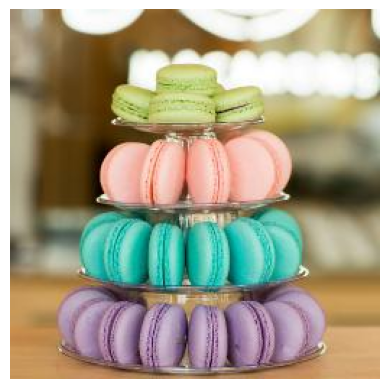

In [ ]:
uploaded = files.upload()

# show image
image_path = next(iter(uploaded))
display_image(image_path)

In [ ]:
# insert label images
while True:
    user_label = input("Enter the image label (number between 0 and 250): ")

    # verify the input
    if user_label.isdigit():
        user_label = int(user_label)
        # verify the value
        if 0 <= user_label <= 250:
            break
        else:
            print("Error: The label must be a number between 0 and 250. Try again")
    else:
        print("Error: Please enter a valid number. Retry")

Enter the image label (number between 0 and 250): 0


#Category Search

In [ ]:
input_image_path = list(uploaded.keys())[0]
input_image = load_and_preprocess_image(input_image_path)
input_features = model.predict(input_image).squeeze()

similarity_scores = cosine_similarity([input_features], list(load_dataset_features.values()))[0]
most_similar_indices = np.argsort(similarity_scores)[-10:][::-1]

most_similar_images = [list(load_dataset_features.keys())[i] for i in most_similar_indices]

1/1 [==============================] - 0s 25ms/step


Immagine: train_059615.jpg, Label: 0, Punteggio: 78.03


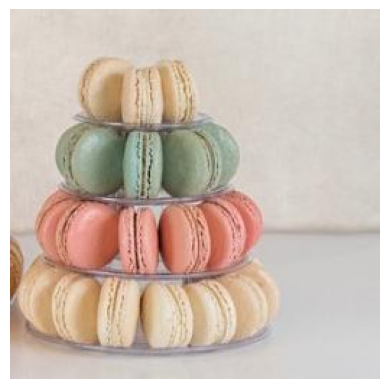

Immagine: train_059702.jpg, Label: 0, Punteggio: 73.62


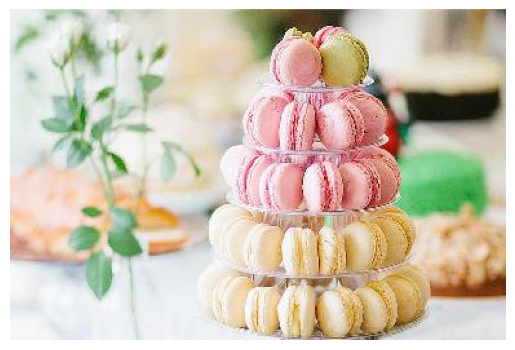

Immagine: train_059397.jpg, Label: 0, Punteggio: 69.66


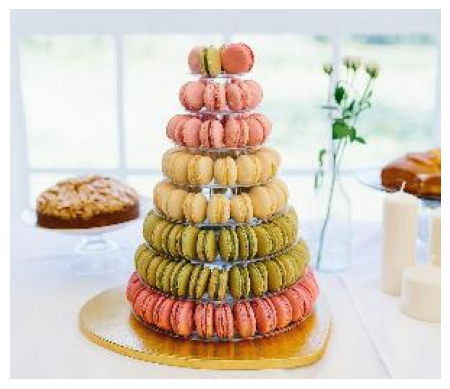

Immagine: train_059365.jpg, Label: 166, Punteggio: 68.36


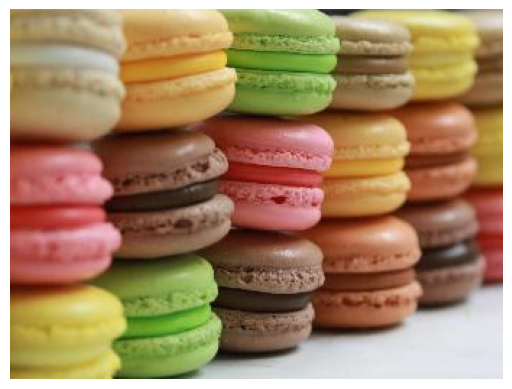

Immagine: train_059780.jpg, Label: 0, Punteggio: 67.24


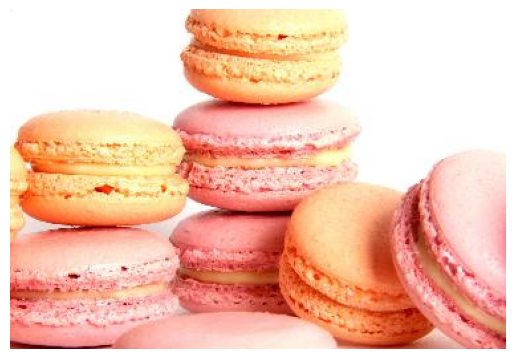

Immagine: train_059570.jpg, Label: 0, Punteggio: 66.64


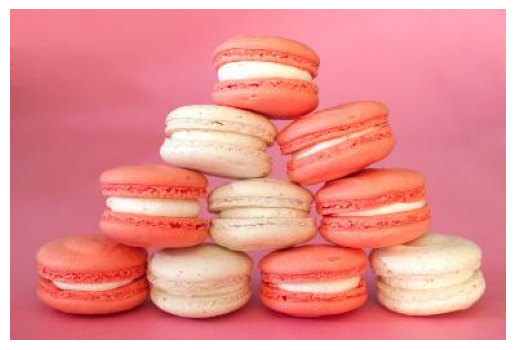

Immagine: train_059513.jpg, Label: 0, Punteggio: 66.63


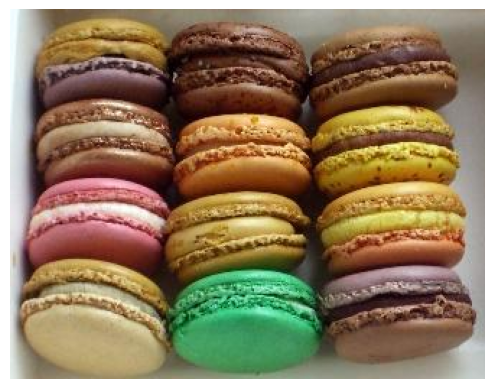

Immagine: train_059763.jpg, Label: 0, Punteggio: 65.46


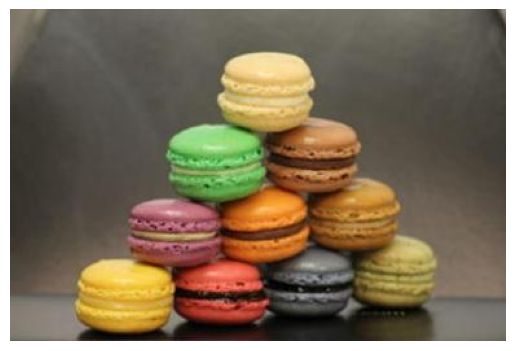

Immagine: train_059906.jpg, Label: 0, Punteggio: 65.34


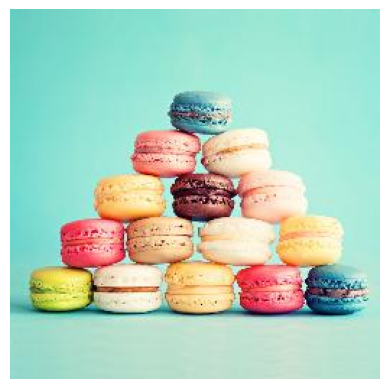

Immagine: train_041147.jpg, Label: 21, Punteggio: 64.45


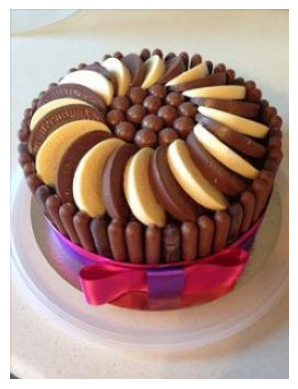


Percentuale di immagini con label identica: 80.00%


In [ ]:
# View the 10 most similar images with their names and scores
same_label_count = 0
for file_name in most_similar_images:
    features = load_dataset_features[file_name]
    image_path = os.path.join(train_path, file_name)
    score = cosine_similarity([input_features], [features])[0][0]
    score = score * 100

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = get_label(file_name, train_df)

    if label == user_label:
        same_label_count += 1

    print(f"Immagine: {file_name}, Label: {label}, Punteggio: {score:.2f}")
    display_image(image_path)

percentage_same_label = (same_label_count / 10) * 100
print(f"\nPercentuale di immagini con label identica: {percentage_same_label:.2f}%")

# Automated test category search

In [ ]:
accuracy_array = []
for i, image_path_test in enumerate(dataset_image_paths_test[:1000]):
  print(f"Image {i+1}/{len(dataset_image_paths_test)} - {image_path_test}")

  img_array = load_and_preprocess_image(image_path_test)
  most_similar_indices = get_most_similar_indices(img_array)
  most_similar_images = [list(load_dataset_features.keys())[i] for i in most_similar_indices]

  file_name_test = os.path.basename(image_path_test)
  label_test = get_label(file_name_test, test_df)

  same_label_count = 0
  for file_name in most_similar_images:
      features = load_dataset_features[file_name]
      image_path = os.path.join(train_path, file_name)
      label = get_label(file_name, train_df)

      if int(label_test) == label:
        same_label_count += 1

  percentage_same_label = (same_label_count / 10) * 100
  accuracy_array.append(percentage_same_label)
  print(f"Correct label: {percentage_same_label}%")

print(f"\nMean of correct label on test set : {np.mean(accuracy_array):.2f}%")
print(f"\nStandard Deviation of correct label on test set : {np.std(accuracy_array):.2f}%")

Image 1/11994 - /content/test/val_set/val_010889.jpg
Correct label: 0.0%
Image 2/11994 - /content/test/val_set/val_010495.jpg
Correct label: 0.0%
Image 3/11994 - /content/test/val_set/val_007646.jpg
Correct label: 20.0%
Image 4/11994 - /content/test/val_set/val_002001.jpg
Correct label: 0.0%
Image 5/11994 - /content/test/val_set/val_007596.jpg
Correct label: 40.0%
Image 6/11994 - /content/test/val_set/val_006393.jpg
Correct label: 0.0%
Image 7/11994 - /content/test/val_set/val_006470.jpg
Correct label: 10.0%
Image 8/11994 - /content/test/val_set/val_006727.jpg
Correct label: 50.0%
Image 9/11994 - /content/test/val_set/val_009421.jpg
Correct label: 50.0%
Image 10/11994 - /content/test/val_set/val_001921.jpg
Correct label: 0.0%
Image 11/11994 - /content/test/val_set/val_008565.jpg
Correct label: 70.0%
Image 12/11994 - /content/test/val_set/val_006877.jpg
Correct label: 10.0%
Image 13/11994 - /content/test/val_set/val_006357.jpg
Correct label: 30.0%
Image 14/11994 - /content/test/val_set/